# 시계열 예측 전처리 + 모델링

### data import

In [37]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'shampoo-three-year.csv'

In [38]:
dataset = pd.read_csv(filename)

In [39]:
dataset = dataset.dropna()

In [40]:
dataset.shape

(36, 2)

### data preview

In [41]:
dataset.head(30)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


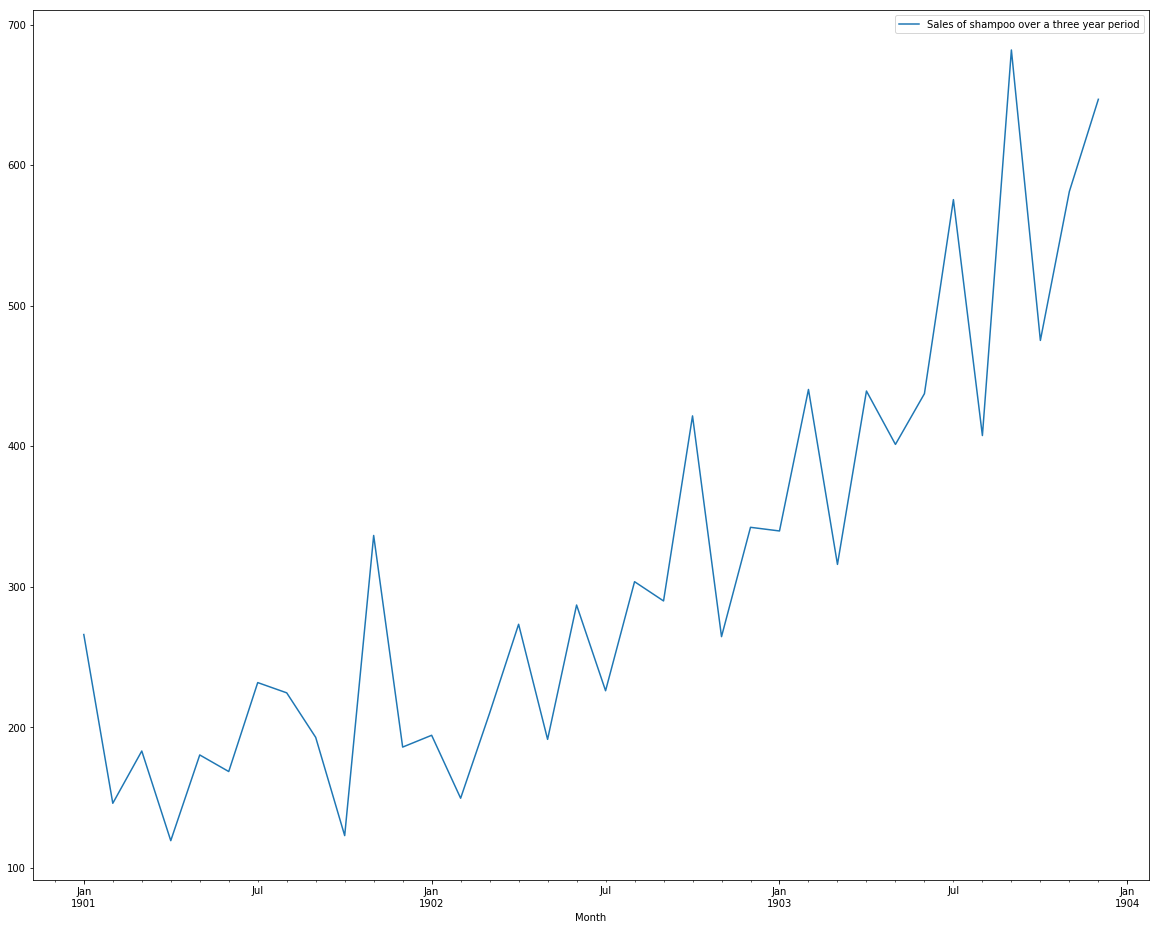

In [42]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

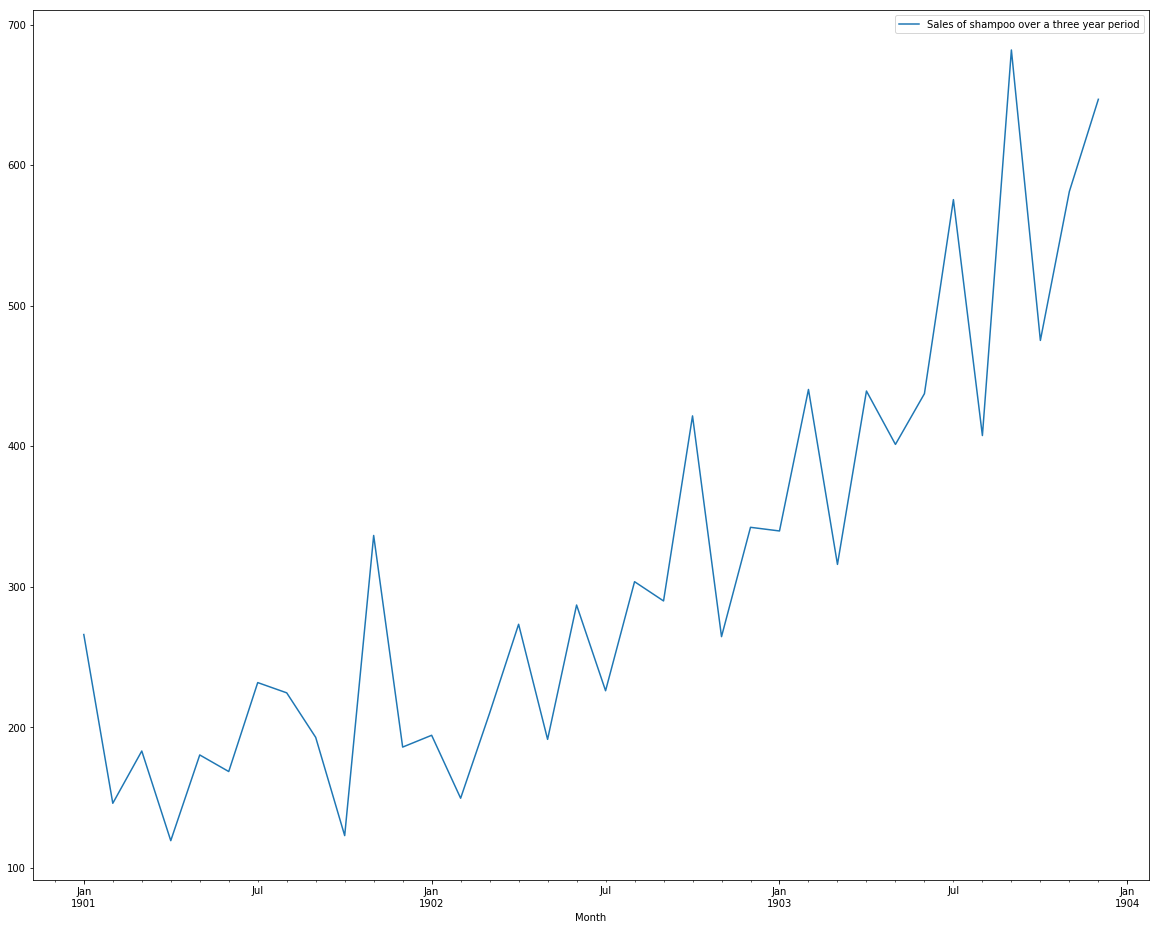

In [43]:
dataset.plot()
plt.rcParams['figure.figsize'] = (20,16)
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [44]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [45]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [46]:
x_train, x_test, y_train, y_test = make_timeseries_dataset(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [47]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


## Modeling 1. Prophet

In [48]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [49]:
from fbprophet import Prophet

### banila prediction (monthly)

In [50]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [54]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [67]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [68]:
forecast_data = m.predict(future_data)

In [69]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,582.655416,509.029085,664.984630
33,1903-10-01,492.576450,411.798633,573.540460
34,1903-11-01,541.283421,459.649374,618.869669
35,1903-12-01,569.945871,486.959608,645.825072
36,1903-12-31,500.410216,412.808700,580.989827


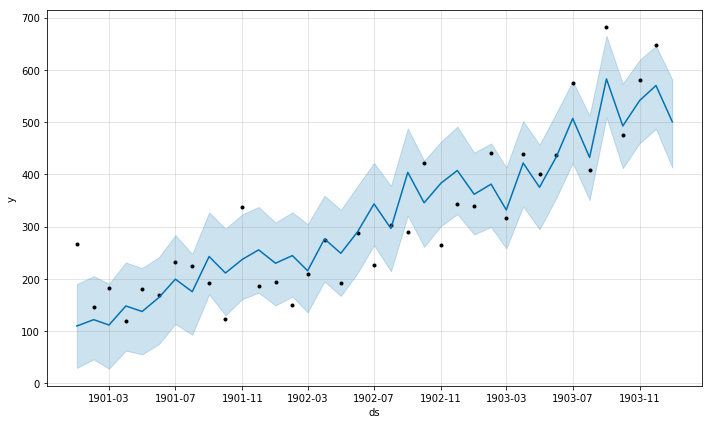

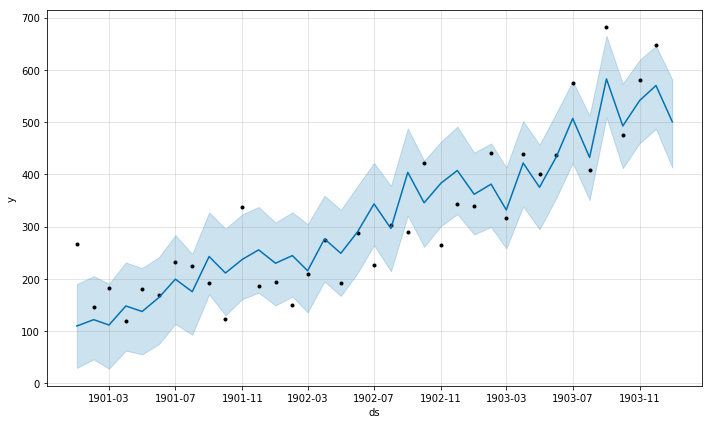

In [73]:
m.plot(forecast_data)

In [75]:
forecast_data.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,1901-01-01,115.953396,115.953396,115.953396,29.418906,189.750814,0.0,0.0,0.0,-0.055206,-0.055206,-0.055206,-0.055206,-0.055206,-0.055206,109.552027
1,1901-02-01,126.766058,126.766058,126.766058,45.804847,205.006978,0.0,0.0,0.0,-0.039653,-0.039653,-0.039653,-0.039653,-0.039653,-0.039653,121.739463
2,1901-03-01,136.532332,136.532332,136.532332,27.852761,190.400039,0.0,0.0,0.0,-0.183439,-0.183439,-0.183439,-0.183439,-0.183439,-0.183439,111.486913
3,1901-04-01,147.344993,147.344993,147.344993,62.430951,231.174857,0.0,0.0,0.0,0.004130,0.004130,0.004130,0.004130,0.004130,0.004130,147.953455
4,1901-05-01,157.808859,157.808859,157.808859,55.200114,220.316002,0.0,0.0,0.0,-0.129300,-0.129300,-0.129300,-0.129300,-0.129300,-0.129300,137.404150


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [111]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [112]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,276.202934,565.112777
33,1903-10-01,396.816812,245.116695,541.228823
34,1903-11-01,400.333321,252.876707,553.206946
35,1903-12-01,422.099080,278.003094,571.835194
36,1903-12-31,380.605378,233.622406,528.150719


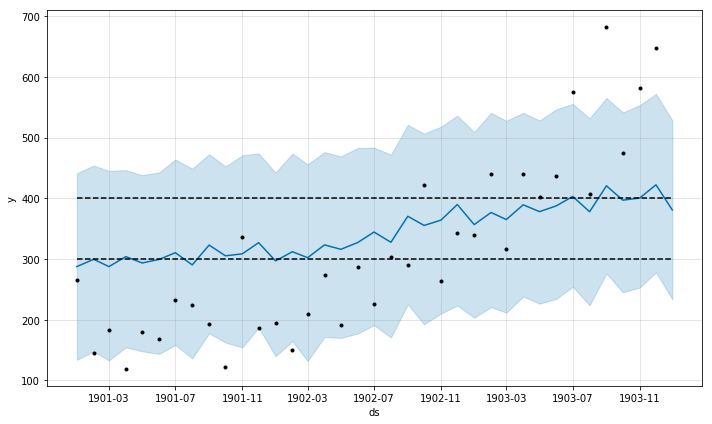

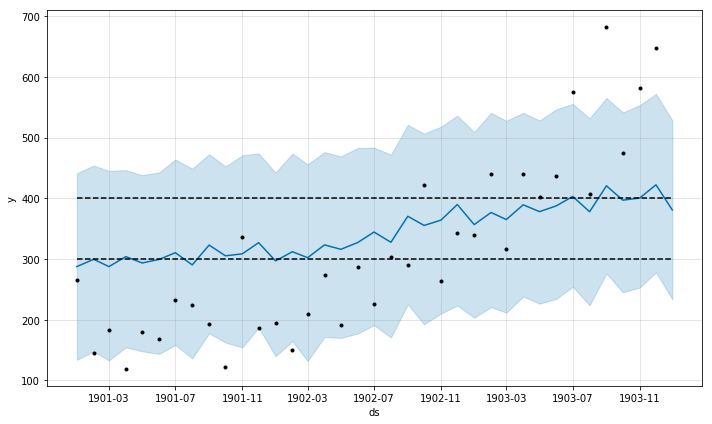

In [113]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [122]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [123]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/anaconda/envs/yoon/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [124]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.662520,414.775624,682.629309
33,1903-10-01,469.502223,338.710995,604.109947
34,1903-11-01,523.148055,379.401199,663.297371
35,1903-12-01,415.565774,279.769734,553.989993
36,1903-12-31,502.168400,357.967417,629.777762


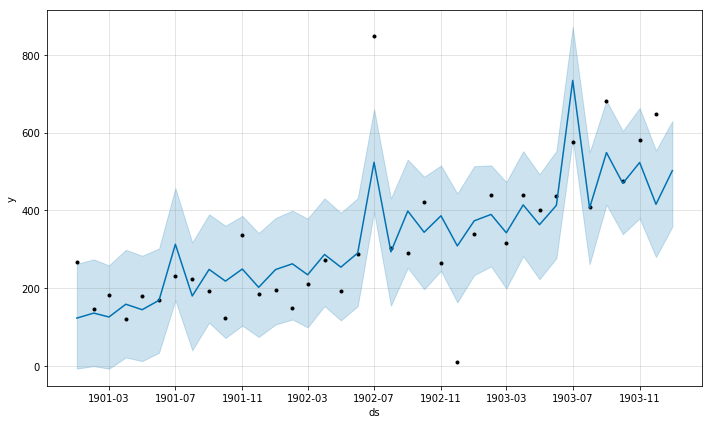

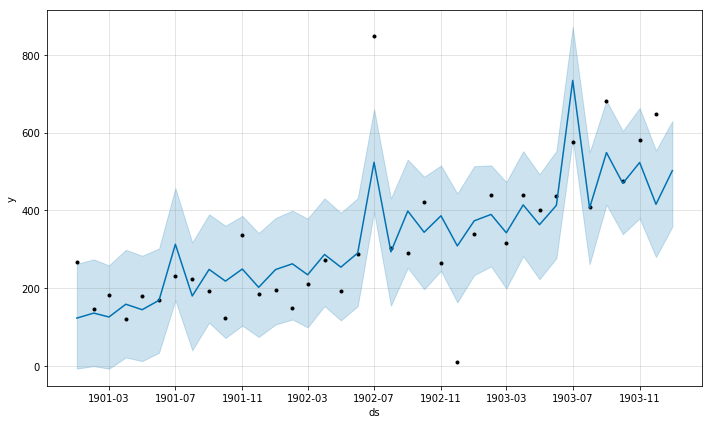

In [125]:
m.plot(forecast_data)

## Modeling 2. ARIMA

## Modeling 3. LSTM